Let's see if I understand the problem:

> An asset listed on a exchange is prone to sharp price fluctuations within a short time scale. This has various reasons such as release of big news, sudden large purchase or release of that asset. These large fluctuations often occur on large exchanges like **Binance** etc.

> Now if a market maker like Fourstroke is trading this asset at a speed slower than the timescale of the fluctuations, the risk of not noticing this rapid change in price and miss on the opportunity to capitalize on this or even worse: they risk of being arbitraged by other market maker 

> The task is to develop an application to track these sharp price fluctuations and warn the trading system such that it can adjust it bid-ask price on time! 

> Basically, create a program that measures the volatility of a given asset with high resolution

For creating this application, I will be developing code on a **google cloud computing engine**. My local computer ram is overloaded and is really slow. This notebook can also be run on my local computer.

Let's concretize this problem is a bit.:
- We will be using data from binance crypto exchange. Later we will generalize this to different exchanges

- Let's first start simple and check the internet for a library which does this for us. Then we can move on optimize stuff.

- Found an interesting library in python that basically acts as a single wrapper around APIs of different crypto exchanges: ccxt (https://github.com/ccxt/ccxt)

Do I need credentials to make use of binance API? Let's first understand how the ccxt API works

# CCXT API

In [1]:
import ccxt
import pandas as pd

In [2]:
print(ccxt.exchanges)

['aax', 'ascendex', 'bequant', 'bibox', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bkex', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcex', 'btcmarkets', 'btctradeua', 'btcturk', 'buda', 'bw', 'bybit', 'bytetrade', 'cdax', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinflex', 'coinmate', 'coinone', 'coinspot', 'crex24', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'eqonex', 'exmo', 'flowbtc', 'fmfwio', 'ftx', 'ftxus', 'gate', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'itbit', 'kraken', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'lbank2', 'liquid', 'luno', 'lykke', 'mercado'

The BTC/USDT Coin-M future is listed on https://www.binance.com/en/delivery/btcusd_perpetual

In [ ]:
coinm = ccxt.binancecoinm()
markets = coinm.load_markets()
print(coinm.id, markets)

In [3]:
pd.DataFrame(ccxt.binancecoinm().fetch_order_book('BTC/USD'))

,symbol,bids,asks,timestamp,datetime,nonce
0,BTC/USD,"[19739.2, 5659.0]","[19739.3, 55.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
1,BTC/USD,"[19739.1, 15.0]","[19739.6, 1.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
2,BTC/USD,"[19739.0, 233.0]","[19739.7, 2.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
3,BTC/USD,"[19738.9, 4.0]","[19740.3, 2.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
4,BTC/USD,"[19738.8, 10.0]","[19740.4, 1.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
...,...,...,...,...,...,...
495,BTC/USD,"[19457.7, 1165.0]","[20015.4, 399.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
496,BTC/USD,"[19456.0, 459.0]","[20015.6, 498.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
497,BTC/USD,"[19455.6, 770.0]","[20015.7, 1596.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543
498,BTC/USD,"[19454.6, 5.0]","[20016.0, 399.0]",1657747608214,2022-07-13T21:26:48.214Z,507946659543


We want to get a continious stream of data. The standard CCXT library does not provide this. The pro version does, but we have to pay for it. Let's check for other libraries which do support websocket data stream.
Found a python-binance-connector library, which automatically opens up a websocket connection for us, sends a request to the server and retrieves the data (https://github.com/binance/binance-futures-connector-python).

# python-binance-connector API

In [4]:
import time
import logging
from binance.lib.utils import config_logging
from binance.websocket.cm_futures.websocket_client import CMFuturesWebsocketClient

config_logging(logging, logging.DEBUG)


def message_handler(message):
    print(message)


my_client = CMFuturesWebsocketClient()
my_client.start()

test = my_client.book_ticker(id=13, callback=message_handler, symbol="btcusd_perp")

time.sleep(5)

logging.debug("closing ws connection")
my_client.stop()

INFO:root:Connection with URL: wss://dstream.binance.com/ws
INFO:root:Start to connect....
INFO:root:Server connected
INFO:root:Sending message to Server: b'{"method": "SUBSCRIBE", "params": ["btcusd_perp@bookTicker"], "id": 13}'


{'id': 13, 'result': None}
{'u': 507946701262, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5174', 'a': '19739.3', 'A': '532', 'T': 1657747618425, 'E': 1657747618430}
{'u': 507946701274, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5419', 'a': '19739.3', 'A': '532', 'T': 1657747618432, 'E': 1657747618439}
{'u': 507946701302, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5174', 'a': '19739.3', 'A': '532', 'T': 1657747618448, 'E': 1657747618455}
{'u': 507946701320, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5581', 'a': '19739.3', 'A': '532', 'T': 1657747618455, 'E': 1657747618462}
{'u': 507946701329, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5806', 'a': '19739.3', 'A': '532', 'T': 1657747618460, 'E': 1657747618465}
{'u': 507946701378, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5806', 'a': '197

{'u': 507946702288, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5423', 'a': '19739.3', 'A': '528', 'T': 1657747618809, 'E': 1657747618814}
{'u': 507946702312, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5632', 'a': '19739.3', 'A': '528', 'T': 1657747618816, 'E': 1657747618823}
{'u': 507946702337, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '6115', 'a': '19739.3', 'A': '528', 'T': 1657747618826, 'E': 1657747618831}
{'u': 507946702362, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5906', 'a': '19739.3', 'A': '528', 'T': 1657747618834, 'E': 1657747618841}
{'u': 507946702423, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '6115', 'a': '19739.3', 'A': '528', 'T': 1657747618845, 'E': 1657747618850}
{'u': 507946702425, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5632', 'a': '19739.3', 'A': '528', 'T': 165

{'u': 507946703595, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '5658', 'a': '19739.3', 'A': '527', 'T': 1657747619085, 'E': 1657747619089}
{'u': 507946703605, 'e': 'bookTicker', 's': 'BTCUSD_PERP', 'ps': 'BTCUSD', 'b': '19739.2', 'B': '6065', 'a': '19739.3', 'A': '527', 'T': 1657747619086, 'E': 1657747619092}


KeyboardInterrupt: 

Ok, now we have managed to get a realtime stream of data of the corresponding symbol into our notebook. Now we need to compute the volatility within a millisecond. Let's see how we can access the data printed in the console. 

Ok, digged into the source code of the binance-future-connector library and apparently this data is coming from a thread: Complicated stuff. I somehow dont seem how I can access to the thread. We can immediately catch the data printed at the output, but that will a overhead.

Let's try another library: unicorn binance library

# unicorn_binance_websocket_api

In [1]:
from unicorn_binance_websocket_api.manager import BinanceWebSocketApiManager
import logging
import os
import time
import threading, queue

import json
from collections import deque
import numpy as np

logging.getLogger("unicorn_binance_websocket_api")

<Logger unicorn_binance_websocket_api (WARNING)>

The way this works: there is a streambuffer which is being supplied with data from the binance server. I think this buffer is locked when data is being dumped from the websocket and released when it's done. When we get data from buffer, we empty the buffer. 
Let's see if we can calculate the volatility from streamed data

In [2]:
def print_stream_data_from_stream_buffer(
    binance_websocket_api_manager, rolling_wdw, dataque, volatility_que
):
    # initialize volatiltiy calculator
    oper = proc_Data(window=rolling_wdw)
    while True:
        #         print('streamsize:',  binance_websocket_api_manager.get_stream_buffer_length())
        if binance_websocket_api_manager.is_manager_stopping():
            exit(0)
        # get data from streambuffer
        data_from_stream_buffer = (
            binance_websocket_api_manager.pop_stream_data_from_stream_buffer()
        )
        if data_from_stream_buffer is False:
            time.sleep(0.01)
        else:
            try:
                data_dict = json.loads(data_from_stream_buffer)
                # uncomment to measure time it takes to calculate volatility
#                 t = time.time()
                data_volatility = oper.calc_volatility(data_dict)
                if data_volatility is not None:
                    # uncomment to measure time it takes to calculate volatility
                    # print ("time to calculate volatility: ", time.time()-t)
                    volatility_que.append(data_volatility)
                #
                dataque.append(
                    [
                        data_dict["data"]["T"],
                        data_dict["data"]["a"],
                        data_dict["data"]["b"],
                    ]
                )

            except KeyError:
                pass


def start_websocket_listener(rolling_wdw, dataque, volatility_que):
    # create instance of BinanceWebSocketApiManager and
    # provide the function for stream processing
    binance_websocket_api_manager = BinanceWebSocketApiManager(
        exchange="binance.com-coin_futures"
    )
    # create streams
    bookTicker_arr_stream_id = binance_websocket_api_manager.create_stream(
        channels="bookTicker", markets="btcusd_perp"
    )

    print("max streamsize:", binance_websocket_api_manager.get_stream_buffer_maxlen())
    # start one worker process (or more) to move the
    # received stream_data from the stream_buffer to a print function
    worker_thread = threading.Thread(
        target=print_stream_data_from_stream_buffer,
        args=(binance_websocket_api_manager, rolling_wdw, dataque, volatility_que),
    )
    worker_thread.start()


class proc_Data:
    def __init__(self, window=200):
        # initializing buffer and rolling window
        self.buffer = deque()
        self.ti = deque()
        self.window = window
        self.flag = False
        self.dt = 0

    def construct_window(self, data_dict):
        if self.flag:
            # remove first element from buffer from the left and add new elements to have
            # a new 200 ms buffer
            self.ti.popleft()
            self.buffer.popleft()
            self.dt = np.sum(np.diff(np.array(self.ti)))
            self.flag = False

        if self.dt <= self.window:  # fill buffer up to 200 ms
            self.ti.append(data_dict["data"]["T"])
            self.buffer.append(
                [data_dict["data"]["T"], data_dict["data"]["b"], data_dict["data"]["a"]]
            )

            self.dt = np.sum(np.diff(np.array(self.ti)))

        else:
            # execute when buffer is full
            self.flag = True
            rol_window = np.array(self.buffer, dtype=np.float64)
            return rol_window

    def calc_volatility(self, data_dict):

        rlw = self.construct_window(data_dict)
        if rlw is None:
            pass

        else:

            _, idx = np.unique(rlw[:, 0], return_index=True)
            _rlw = np.zeros((len(idx), 2))
            _rlw[:, 0] = rlw[idx, 0]  # timestamp
            _rlw[:, 1] = (rlw[idx, 1] + rlw[idx, 2]) / 2  # midprice
            diff_arr = np.diff(_rlw, axis=0)  # difference (midprice_t - midprice_t-1)
            volt_t = np.sum(
                np.abs(diff_arr[:, 1] / _rlw[1:, 1]) / diff_arr[:, 0]
            ) / len(diff_arr)  # rolling derivative average

            return [_rlw[-1, 0], volt_t]


# deque datastructures have O(1) complexity, whereas lists have O(n) when indexing or using pop,
# see test below

dataque = deque()  # Que to store realtime stream
volatility_que = deque()  # Que to store volatility
rolling_wdw = 200  # ms
start_websocket_listener(
    rolling_wdw, dataque, volatility_que
)  # start stream and store data in ques

max streamsize: None


Ok, what have we done till so far?

- I am able to get orderbook data from the server. One thing I notice, is that the server bid/ask prices obtained with the current API does not match the price in our browser; why is that?

- I implemented a rolling window that calculated the volatility of a given asset. The window size is adjustable

- I notice that there are multiple orders that occurred at the same transaction time, but also several orders that contain the same price. I remove those that happened at the same time, because those have the same price and therefore do not add any new information

- Lastly, when I remove all the print statement, my code is able to calculate the volatility in below a millisecond (unit below is seconds). On average 200/300 microseconds <br>
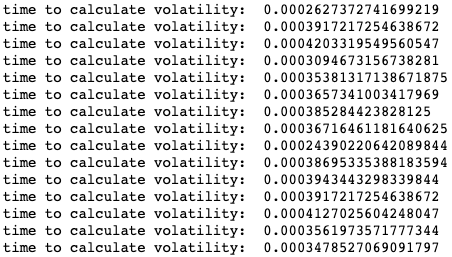

- It is possible to do this faster. We have to code the function that calculates the volatility in C and then call this using cython.

- Let's see if we can plot this streaming data 

The volatility metric is calculated with <br>
midprice = m(t) <br>
askprice = a(t) <br>
bidprice = b(t) <br>
$\rm m(t)  = \frac{b(t) + a(t)}{2}$<br>
$\rm Volatility = \frac{1}{n} \sum_t \bigl|\frac{\frac{m(t) - m(t-1)}{m(t)}}{dt}\bigr| $

Looks like an average of the time derivative of the midprice ( to get this in percentage/s, multiply by 1e5). 

# Plotly/Dash: plotting live data

In [3]:
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly
import plotly.graph_objs as go
import pandas as pd

# configuring plotly parameters and used Dash app to plot live price and
# volatility data in browser
class display_bookTicker:
    
    def __init__(self, datastream, voltstream):
        self.stream = datastream
        self.vstream = voltstream
        self.t_stamp = deque()
        self.volt_t_stamp = deque()
        self.price = deque()

        self.app = dash.Dash()
        # configuring layout in browser
        self.app.layout = html.Div(
            [
                html.Div(
                    [
                        html.H1(
                            children="COIN-M BTCUSDT (perp) LIVE TRACKING",
                            style={"color": "#d486f0", "backgroundColor": "#18191c",},
                        )
                    ],
                    className="row",
                ),
                html.Div(
                    [  ### FIGURES Divs
                        html.Div(
                            [
                                dcc.Graph(id="fig_1",),
                                dcc.Interval(
                                    id="fig_1_update", interval=1200, n_intervals=0
                                ),
                            ],
                            className="pricefig",
                        ),
                        html.Div(
                            [
                                dcc.Graph(id="fig_2"),
                                dcc.Interval(
                                    id="fig_2_update", interval=1200, n_intervals=0
                                ),
                            ],
                            className="voltfig",
                        ),
                    ],
                    className="row",
                ),
            ]
        )
        # call back to continiously update figures
        self.app.callback(
            [Output("fig_1", "figure"), Output("fig_2", "figure")],
            Input("fig_1_update", "n_intervals"),
        )(self.update_graph)

    # callback function
    def update_graph(self, n):
        _tempdata = np.array(self.stream, dtype=np.float64)
        _timest = pd.Series(_tempdata[:, 0]) * 1e-3
        timest = pd.to_datetime(_timest, unit="s")

        fig_1 = go.Figure(
            data=[
                go.Scatter(
                    x=timest, y=_tempdata[:, 1], name="askprice", showlegend=True
                ),
                go.Scatter(
                    x=timest,
                    y=_tempdata[:, 2],
                    name="bidprice",
                    showlegend=True,
                    marker=dict(color="green"),
                ),
            ],
        )

        fig_1.update_layout(title="price", yaxis=dict(tickformat=".1f"))

        _tempvoltdata = np.array(self.vstream, dtype=np.float64)
        _timestvolt = pd.Series(_tempvoltdata[:, 0]) * 1e-3
        timestvolt = pd.to_datetime(_timestvolt, unit="s")

        fig_2 = go.Figure(
            data=go.Scatter(
                x=timestvolt,
                y=_tempvoltdata[:, 1] * 1e5,
                name="Volatility",
                showlegend=True,
                marker=dict(color="red"),
            )
        )

        fig_2.update_layout(
            title="Volatility",
            yaxis=dict(tickformat=".2f", title="Percentage Change/s"),
        )

        return [fig_1, fig_2]


if __name__ == "__main__":
    show_ticker = display_bookTicker(dataque, volatility_que)
    # I run this code on google cloud computing engine on port 8050
    show_ticker.app.run_server(host="10.164.0.4", port="8050")

Dash is running on http://10.164.0.4:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://10.164.0.4:8050/ (Press CTRL+C to quit)
92.110.1.169 - - [13/Jul/2022 21:29:25] "POST /_dash-update-component HTTP/1.1" 200 -
92.110.1.169 - - [13/Jul/2022 21:29:26] "POST /_dash-update-component HTTP/1.1" 200 -
92.110.1.169 - - [13/Jul/2022 21:29:28] "POST /_dash-update-component HTTP/1.1" 200 -


For demonstration purposes of what the plotting code above displays
<img src="livetracking.gif" width="750" align="center">

Live tracker is based on https://www.binance.com/en/futures/BTCUSDT

# Testing 

In [4]:
for thread in threading.enumerate(): 
    print(thread.name)

MainThread
IOPub
Heartbeat
Thread-3
Thread-4
Control
IPythonHistorySavingThread
Thread-2
frequent_checks
keepalive_streams
_create_stream_thread:  stream_id=2c3fd504ecbc-c03d-2248-9398-55eeb599, time=1657747760.2326465
ThreadPoolExecutor-0_0
Thread-6


What's the difference in performance between using list and deque for storing data and obtaining data. For example in using a rolling window to remove and add new elements

In [5]:
s = list(range(10000000))

d = deque(s)

s_append, s_pop = s.append, s.pop

d_append, d_pop = d.append, d.popleft

%timeit s_pop(0); s_append(None)

%timeit d_pop(); d_append(None)

6.88 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62.1 ns ± 1.23 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Deques have O(1) speed for appendleft() and popleft() while lists have O(n) performance for insert(0, value) and pop(0).